# Goal: prepare logical $\ket{\overline{+}}$ state

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ldpc.codes import rep_code
from bposd.css import css_code
from bposd.hgp import hgp
from ldpc import bposd_decoder
from ldpc.code_util import codewords, compute_code_distance, systematic_form, construct_generator_matrix, get_code_parameters, get_ldpc_params, search_cycles
from ldpc.mod2 import rank
from scipy.sparse import csc_matrix
import networkx as nx
from networkx.algorithms.bipartite import configuration_model, biadjacency_matrix
from multiprocess import Pool
import X_error_sim, X_error_sim_trad, Z_error_sim_full_dec, Z_error_sim_ss_dec
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = True

# Basic functions

In [2]:
def f(p,a):
    return 1-(1-p)**a

def df(p,a):
    return a*(1-p)**(a-1)

## Sample HGP parent codes

In [43]:
n = 18
d_v = 5
d_c = 6

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
print(compute_code_distance(H), rank(H))

9 15


In [46]:
code = hgp(h1=H, h2=H, compute_distance=True)
code.test()

<Unnamed CSS code>, (6,11)-[[549,9,9]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (6,11)-[[549,9,9]]


True

# Run simulation of $X$ errors

In [47]:
res = 10
p_min = 5E-3
p_max = 5E-2
z_list = [1,3,5]
iters = np.logspace(5,2,res, dtype=int)
PROCESSES = 20

iters = iters//PROCESSES*PROCESSES
logical_error_probs = np.zeros([len(z_list),res])
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
pool = Pool(processes=PROCESSES)

for w in range(len(z_list)):
    for r in range(res):
        print('z: {} / {} , Res: {} / {}        '.format(w+1,len(z_list),r+1,res), end='\r')
        params = (code, [20,20], p_list[r], p_list[r], iters[r]//PROCESSES, z_list[w])
        args = [params for i in range(PROCESSES)]
        if __name__ ==  '__main__':
            failures = pool.starmap(X_error_sim.get_BPOSD_failures, args)
        logical_error_probs[w,r] = np.sum(failures) / iters[r]
pool.close()

### Load simulation data

In [3]:
p_list = np.loadtxt('Data/p_list_x.txt')
iters = np.loadtxt('Data/iters_x.txt')
logical_error_probs = np.loadtxt('Data/[20,4,8]_HGP_z=1_3_5.txt')
z_list = [1,3,5]

### Process simulation data

In [48]:
logical_error_std = np.sqrt(logical_error_probs*(1-logical_error_probs)/iters)

### Save simulation data

In [63]:
# np.savetxt('Data/[18,3,9]_code.txt', H, fmt='%g')
# np.savetxt('Data/p_list_x.txt', p_list)
# np.savetxt('Data/iters_x.txt', iters//PROCESSES*PROCESSES)
# np.savetxt('Data/[18,3,9]_HGP_z=1_3_5.txt', logical_error_probs)

# Run traditional simulation of multiple rounds of QEC

In [49]:
res = 10
p_min = 5E-3
p_max = 5E-2
z_list = [1,3,5]
iters2 = np.logspace(5,2,res, dtype=int)
PROCESSES = 20

iters2 = iters2//PROCESSES*PROCESSES
logical_error_probs2 = np.zeros([len(z_list),res])
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
pool = Pool(processes=PROCESSES)

for w in range(len(z_list)):
    for r in range(res):
        print('z: {} / {} , Res: {} / {}        '.format(w+1,len(z_list),r+1,res), end='\r')
        params = (code, [20,20], p_list[r], p_list[r], iters2[r]//PROCESSES, z_list[w]-1)
        args = [params for i in range(PROCESSES)]
        if __name__ ==  '__main__':
            failures = pool.starmap(X_error_sim_trad.get_BPOSD_failures, args)
        logical_error_probs2[w,r] = np.sum(failures) / iters2[r]
pool.close()

### Load simulation data

In [3]:
p_list = np.loadtxt('Data/p_list_x.txt')
iters2 = np.loadtxt('Data/iters_x.txt')
logical_error_probs2 = np.loadtxt('Data/[20,4,8]_HGP_z=1_3_5.txt')
z_list = [1,3,5]

### Process simulation data

In [50]:
logical_error_std2 = np.sqrt(logical_error_probs2*(1-logical_error_probs2)/iters2)

### Save simulation data

In [64]:
# np.savetxt('Data/p_list_x.txt', p_list)
# np.savetxt('Data/iters_x.txt', iters//PROCESSES*PROCESSES)
# np.savetxt('Data/[18,3,9]_HGP_trad_t=1_3_5.txt', logical_error_probs2)

### Plot simulation data

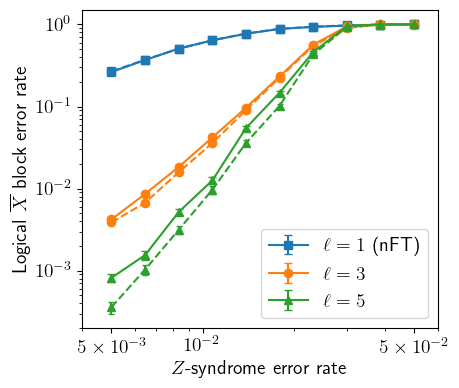

In [62]:
plt.figure(figsize=[4.8,4.1])
cutoffs1 = [np.arange(0,10), np.arange(0,10), np.arange(0,10), np.arange(0,10)]
fmt1 = ['s-', 'o-', '^-', 'D-']
fmt2 = ['s--', 'o--', '^--', 'D-']
colors = ['tab:blue', 'tab:orange', 'tab:green']
for i in range(len(z_list)):
    if z_list[i]==1: label=r'$\ell={}$ (nFT)'
    else: label=r'$\ell={}$'
    plt.errorbar(p_list[cutoffs1[i]], logical_error_probs[i][cutoffs1[i]], yerr=logical_error_std[i][cutoffs1[i]], 
            fmt=fmt1[i], color=colors[i], capsize=3, label=label.format(z_list[i]))
    plt.errorbar(p_list[cutoffs1[i]], logical_error_probs2[i][cutoffs1[i]], yerr=logical_error_std2[i][cutoffs1[i]], 
            fmt=fmt2[i], color=colors[i], capsize=2)
plt.xlabel('$Z$-syndrome error rate', fontsize=14)
plt.ylabel('Logical $\\overline{X}$ block error rate', fontsize=14)
# plt.title('$[\![656,16,8]\!]$ HGP')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=14, loc='lower right')
plt.xticks([min(p_list), *plt.xticks()[0], max(p_list)], 
           labels=['$5\\times 10^{-3}$', *plt.xticks()[1], '$5\\times 10^{-2}$'])
plt.xlim([4E-3,6E-2])
plt.tight_layout()
# plt.savefig('Plots/BLER_X_different_z.pdf')

# __________________________________________________________________________
# Second simulation
# __________________________________________________________________________

## Sample HGP parent codes

In [13]:
H_list = []

In [25]:
n = 24
d_v = 5
d_c = 6

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
print(compute_code_distance(H), rank(H))

9 20


In [26]:
H_list.append(H)

In [27]:
code_list = []
d_list = []
for H in H_list:
    code = hgp(h1=H, h2=H, compute_distance=True)
    code_list.append(code)
    d_list.append(code.D)
d_list = np.array(d_list)

In [88]:
code_list[3] = hgp(h1=H, h2=H, compute_distance=True)
d_list[3] = code_list[3].D

# Run simulation of $Z$ errors

In [101]:
res = 10
p_min = 3E-3
p_max = 2E-2
z_list = d_list.copy()
iters = np.logspace(5,2.5,res, dtype=int)
PROCESSES = 15

iters = iters//PROCESSES*PROCESSES
logical_error_probs = np.zeros([len(z_list),res])
p_list = np.logspace(np.log10(p_min), np.log10(p_max), res)
pool = Pool(processes=PROCESSES)

for w in range(len(z_list)):
# for w in range(3,4):
    code = code_list[w]
    for r in range(res):
        print('z: {} / {} , Res: {} / {}        '.format(w+1,len(z_list),r+1,res), end='\r')
        params = (code, [20,20], p_list[r], iters[r]//PROCESSES, z_list[w])
        args = [params for i in range(PROCESSES)]
        if __name__ ==  '__main__':
            failures = pool.starmap(Z_error_sim_ss_dec.get_BPOSD_failures, args)
        logical_error_probs[w,r] = np.sum(failures) / iters[r]
pool.close()

In [87]:
cycles = 20000
pool = Pool(processes=PROCESSES)
params = (code_list[3], [20,20], 3E-3, cycles//PROCESSES, 15)
args = [params for i in range(PROCESSES)]
if __name__ ==  '__main__':
    failures = pool.starmap(Z_error_sim_ss_dec.get_BPOSD_failures, args)
pool.close()
print(np.sum(failures) / cycles)

0.0001


### Save simulation data

In [581]:
# np.savetxt('Data/p_list_z.txt', p_list)
# np.savetxt('Data/iters_z.txt', iters)
# np.savetxt('Data/Z_sim_HGP_d=5_7_9.txt', logical_error_probs)

### Load simulation data

In [28]:
p_list = np.loadtxt('Data/p_list_z.txt')
iters = np.loadtxt('Data/iters_z.txt')
logical_error_probs = np.loadtxt('Data/Z_sim_HGP_d=5_7_9.txt')
z_list = [5,7,9]

### Process simulation data

In [29]:
def f(p,a):
    return 1-(1-p)**a

def df(p,a):
    return a*(1-p)**(a-1)

logical_error_std = np.sqrt(logical_error_probs*(1-logical_error_probs)/iters)

### Plot simulation data

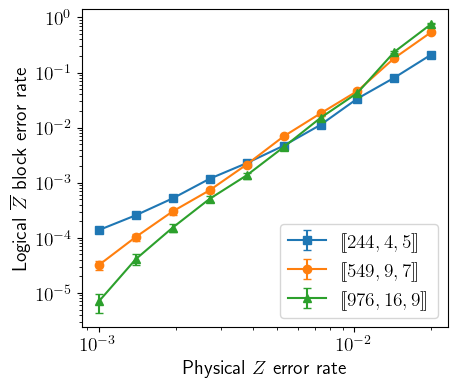

In [32]:
plt.figure(figsize=[4.8,4.1])
cutoffs1 = [np.arange(0,10), np.arange(0,10), np.arange(0,10), np.arange(0,10)]
fmt1 = ['s-', 'o-', '^-', 'D-']
for i in range(len(z_list)):
    plt.errorbar(p_list[cutoffs1[i]], logical_error_probs[i][cutoffs1[i]], yerr=logical_error_std[i][cutoffs1[i]], 
            fmt=fmt1[i], capsize=3, label=r'$[\![{},{},{}]\!]$'.format(code_list[i].N, code_list[i].K, code_list[i].D))
plt.xlabel('Physical $Z$ error rate', fontsize=14)
plt.ylabel('Logical $\\overline{Z}$ block error rate', fontsize=14)
# plt.title('$[\![656,16,8]\!]$ HGP')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=14, loc='lower right')
# plt.xticks([min(p_list), *plt.xticks()[0], max(p_list)], 
#            labels=['$5\\times 10^{-3}$', *plt.xticks()[1], '$5\\times 10^{-2}$'])
# plt.xlim([4E-3,6E-2])
plt.tight_layout()
# plt.savefig('Plots/BLER_Z_different_HGP.pdf')

### 